In [1]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [2]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram

Generation of the covariance matrix and normalization

In [38]:
#number of features
N = 6

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)

covmat = np.dot(centered.transpose(),centered)
covmat=covmat/np.trace(covmat)
print(covmat)
eigval, eigvec = np.linalg.eig(covmat)
print("Eigenvalues: ")
print(eigval)
print("Eigenvectors: ")
print(eigvec)

[[ 0.13787404 -0.03274586 -0.00588502  0.03215981 -0.01049204 -0.04495985]
 [-0.03274586  0.17638559 -0.1025097   0.04500853  0.06123386 -0.06087956]
 [-0.00588502 -0.1025097   0.12878577 -0.05475289 -0.10065082  0.04080508]
 [ 0.03215981  0.04500853 -0.05475289  0.17947414  0.0983792  -0.03755522]
 [-0.01049204  0.06123386 -0.10065082  0.0983792   0.22856197 -0.10829825]
 [-0.04495985 -0.06087956  0.04080508 -0.03755522 -0.10829825  0.14891849]]
Eigenvalues: 
[0.47056312 0.00864489 0.19275969 0.0682468  0.12676968 0.13301583]
Eigenvectors: 
[[-0.03861396  0.36311065  0.68455828 -0.31200694 -0.38770168 -0.38778687]
 [-0.4037576   0.43990216 -0.54918984  0.26392916 -0.41914695 -0.31066645]
 [ 0.40877819  0.52501328  0.2217146   0.66836297  0.23891875  0.06567228]
 [-0.39693041 -0.1639933   0.32619322  0.36216059 -0.44564176  0.61594932]
 [-0.60333828  0.42430491  0.09787151 -0.22824192  0.58450006  0.2294226 ]
 [ 0.38316878  0.43825718 -0.25422876 -0.45058777 -0.27691907  0.56282019]]


In [55]:
bits = 7
#initial = np.random.rand(6)*2 - 1
initial = [ 0.04699447, 0.41022703, -0.41183893,  0.40644107,  0.58620779, -0.38866447]
res=qpca(covmat,bits,initialeig= initial ,iterations=1)

print(res.get_eigvals())

first_approx [ 0.04699447  0.41022703 -0.41183893  0.40644107  0.58620779 -0.38866447
  0.          0.        ]
last_approx [ 0.04699447  0.41022703 -0.41183893  0.40644107  0.58620779 -0.38866447
  0.          0.        ]
{0.4296875: 22, 0.4921875: 68, 0.875: 2, 0.4375: 31, 0.53125: 6, 0.4453125: 45, 0.5546875: 5, 0.5078125: 19, 0.4140625: 9, 0.125: 6, 0.515625: 18, 0.46875: 9118, 0.3203125: 5, 0.4765625: 808, 0.7265625: 3, 0.4609375: 351, 0.65625: 1, 0.375: 1, 0.7109375: 1, 0.1328125: 2, 0.2734375: 1, 0.0078125: 1, 0.578125: 2, 0.390625: 3, 0.5234375: 14, 0.671875: 1, 0.96875: 1, 0.3046875: 2, 0.3359375: 2, 0.8203125: 1, 0.2890625: 1, 0.90625: 1, 0.265625: 2, 0.7421875: 2, 0.21875: 1, 0.203125: 2, 0.5859375: 3, 0.640625: 2, 0.8671875: 2, 0.3515625: 6, 0.359375: 2, 0.3671875: 1, 0.5625: 2, 0.625: 1, 0.5390625: 2, 0.734375: 1, 0.7890625: 1, 0.328125: 1, 0.015625: 1, 0.25: 1, 0.703125: 2, 0.1953125: 1, 0.609375: 1, 0.078125: 2, 0.75: 1, 0.234375: 1, 0.0859375: 1, 0.3828125: 3, 0.890625:

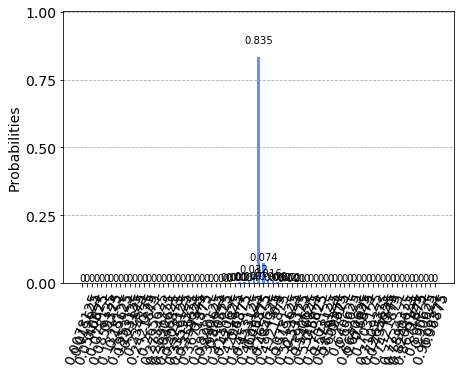

In [56]:
plot_histogram(res.get_eigvals(False))

In [57]:
eigval_to_find = 0.46875
eigv = res.eigvec_from_eigval(eigval_to_find)
print(eigv)

[[ 0.03628973  0.41217213 -0.39531941  0.38859961  0.61656957 -0.37596817
  -0.         -0.        ]]
